# 02805 Social Graphs and Interactions, Fall 2024

## Project Assignment B

Group members:
 - Ana Marija Pavicic (s232468)
 - Inês	Da Fonseca Tacanho (s232669)
 - Raquel Moleiro Marques (s243636)

#### Imports

In [28]:
# Requirements
import re
import os
import sys
import math
import nltk
import json
import random
import urllib
import pickle
import statistics
import unicodedata
import numpy as np
import pandas as pd
import polars as pl
from PIL import Image
from math import sqrt
import colorcet as cc
from tqdm import tqdm
import seaborn as sns
import networkx as nx
from numpy import amax
from numpy import array
from numpy import trace
import tensorflow as tf
from numpy import square
import cartopy.crs as ccrs
from numpy import concatenate
from scipy.sparse import diags
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import pearsonr
from scipy.sparse import identity
from nltk.corpus import stopwords
import cartopy.feature as cfeature
from scipy.sparse import dok_matrix
from scipy.sparse import csc_matrix
from fa2_modified import ForceAtlas2
import community as community_louvain
from traceback import format_exception
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import percentileofscore
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from cartopy.io.shapereader import natural_earth
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import euclidean, cityblock, canberra
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Table of content
- ### Introduction
- ### Flight network creatiion
- ### Community detection
- ### Data scrapping and cleaning
- ### Influence of population on the degree centrality and distribution
- ### Calculate similarty between cities based on the history and demography text
- ### Comparions between flight network graph and graphs based on similarities between the cities

# Introduction

With this study we aim to explore the factors which shape the global flight network beyond geography, focusing on historical relationships, population size, and country boundaries. By collecting data on cities' histories from Wikipedia, flight routes, and airport datasets, we look into how these aspects influence connectivity. We seek to close the gap between network science and real-world data, by uncovering whether historical similarities, population, or shared borders define cities' interactions in the global air travel network.

# Flight network creation

This section goes through how the data used in our study was taken out and prepared. We begin by getting the city information from the airports' dataset as well as the connection details from the flight route dataset, enabling us to have a good foundation structure of the global flight network.

### *Prelimenary data anlysis and cleaning of datasets (Ana Marija, Ines)*
To make sure the datasets are compatible and network creation is possible we clean the data and map the name of the city to the IATA code of it's airport.

In [29]:
file_path_airports = 'airports.csv'
file_path_routes = 'routes.csv'

airports = pd.read_csv(file_path_airports)
routes = pd.read_csv(file_path_routes)

# clean and display airports data 

# Extract unique cities from the 'City' column
print(f"Number of unique cities in the dataset: {len(set(airports['City']))}")

# Create dictionary with IATA as key and City as value
# Note that IATA stands for International Air Transport Association airport code
airport_city_dict = airports.set_index('IATA')['City'].to_dict()

# Remove nan values
airport_city_dict = {key: value for key, value in airport_city_dict.items() if not pd.isna(value)}
print(f"Number of unique IATA codes in the dataset: {len(airport_city_dict.keys())}")

# clean and check routes compatibility with airports dataset

# Filter rows where stops == 0
direct_flights = routes[routes['Stops'] == 0]

# Making sure that we are extracting the right data
# Extract source airports and destination airports from direct flights
source_airports_set = set(direct_flights['Source Airport'])
dest_airports_set = set(direct_flights['Destination Airport'])

# Extract the set of airports that have corresponding cities from the airport_city_dict
airports_set = set(airport_city_dict.keys())

# Find the intersection between destination airports from direct flights and airports with cities
combined_airports = dest_airports_set.intersection(airports_set)

print(f"Number of airports that are in both direct flights and have city data: {len(combined_airports)}")

Number of unique cities in the dataset: 6956
Number of unique IATA codes in the dataset: 6034
Number of airports that are in both direct flights and have city data: 3254


### *Creating a Directed Graph of Direct Flights (Ana Marija, Ines)*
In the present section, we construct a directed graph representing the global flight network, by using flight route and airports datasets.

In [30]:
G_directed = nx.DiGraph()

for index, row in direct_flights.iterrows():
   # get airport code
   source_airport = row['Source Airport']
   destination_airport = row['Destination Airport']
   airline = row['Airline']
   airline_id = row['Airline ID']

   # Check if the airport codes exist in the dictionary
   if source_airport in airport_city_dict and destination_airport in airport_city_dict:
      # Get city names based on airport codes
      source_city = airport_city_dict[source_airport]
      destination_city = airport_city_dict[destination_airport]

       # Check if the edge already exists
      if G_directed.has_edge(source_city, destination_city):
         # Increment the weight attribute
         G_directed[source_city][destination_city]['weight'] += 1
      else:
         # Add a new edge with weight = 1 and other attributes
         G_directed.add_edge(source_city, destination_city, weight=1, Airline=airline, Airline_ID=airline_id)

print(f"The directed network has {len(G_directed.nodes())} nodes and {len(G_directed.edges())} edges")

The directed network has 3135 nodes and 34610 edges


### *Edge Weight Distribution of Directed Graph (Raquel)*
Besed on the graph we can see the half of the edges have weight 1.

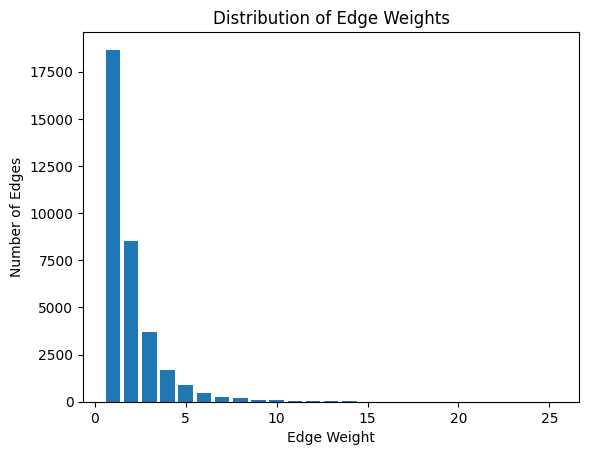

In [31]:
# Extract edge weights from the graph
edge_weights = [data['weight'] for _, _, data in G_directed.edges(data=True)]

# Count occurrences of each weight
weight_distribution = Counter(edge_weights)


# Visualize the edge weight distribution
plt.bar(weight_distribution.keys(), weight_distribution.values())
plt.xlabel('Edge Weight')
plt.ylabel('Number of Edges')
plt.title('Distribution of Edge Weights')
plt.show()

### *Turn the Directed Graph into Undirected (Rquel)*
Converting directed to an undirected graph allows us to get the desired analysis and visualizations for the project.

In [32]:
G_undirected = nx.Graph()

# Iterate through all edges in the directed graph G
for u, v, data in G_directed.edges(data=True):
    weight = data['weight']  # Get the weight (number of flights)

    # If the edge already exists in the undirected graph, sum the weights
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]['weight'] += weight
    else:
        # Otherwise, add the edge with the initial weight
        G_undirected.add_edge(u, v, weight=weight)

# Display the number of nodes and edges in the undirected graph
print(f"The undirected graph has {len(G_undirected.nodes())} nodes and {len(G_undirected.edges())} edges")

The undirected graph has 3135 nodes and 17694 edges


### *Add Latitude and Longitude to nodes for Vizualization (Ines)*
To make this final visualization possible, latitude and longitude data is also added to the graph, so that we can plot the cities and their connections on a world map, as shown below.

In [33]:
# Create a mutable copy of the frozen graph
G = nx.Graph(G_undirected)

# List to store nodes without matching coordinates
nodes_to_remove = []

for node in list(G_undirected.nodes()):
    # Filter the DataFrame for matching city
    matched_rows = airports.loc[airports['City'] == node, ['Latitude', 'Longitude']]

    if not matched_rows.empty:
        # Extract latitude and longitude if a match is found
        lat, lon = matched_rows.values[0]
        G.nodes[node]['coords'] = (lon, lat)
    else:
        # Add the node to the removal list
        print(f"Coordinates not found for node: {node}")
        nodes_to_remove.append(node)

# Remove nodes that do not have matching coordinates
G.remove_nodes_from(nodes_to_remove)

print(f"Removed {len(nodes_to_remove)} nodes without coordinates.")
print(f"Remaining nodes in graph: {len(G.nodes())}")

Removed 0 nodes without coordinates.
Remaining nodes in graph: 3135


### *VIsualize the graph (Ines)*

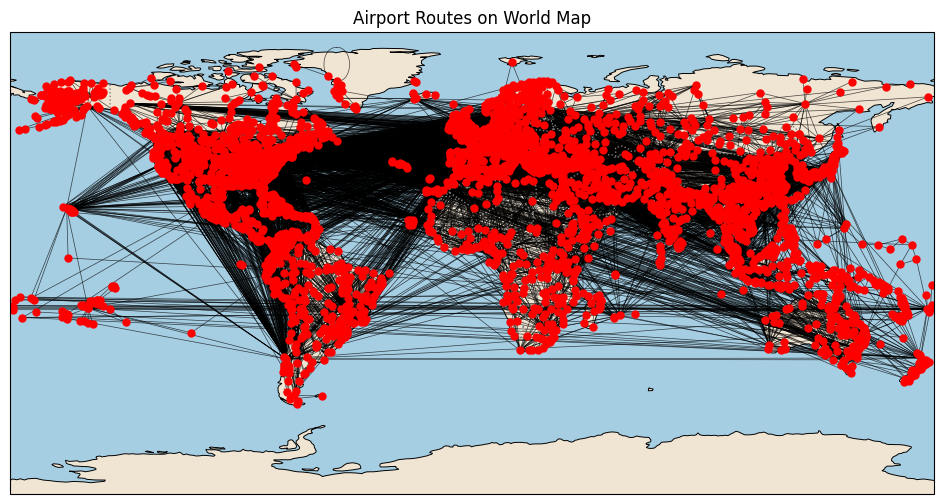

In [34]:
positions = {node: data['coords'] for node, data in G.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

# Draw the graph
nx.draw_networkx_edges(G, positions, ax=ax, edge_color='black', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G, positions, ax=ax, node_size=25, node_color='red')

# Show the plot
plt.title("Airport Routes on World Map")
plt.show()

### Saving and loading the graph to pickle

In [51]:
# Save the graph to a file using pickle
with open('flight_network_graph.pickle', 'wb') as f:
   pickle.dump(G, f)

In [52]:
# Load the graph from the pickle file
with open('flight_network_graph.pickle', 'rb') as f:
   G = pickle.load(f)

# Community detection

### *Disparity Filter (Raquel)*

The idea behind applying the disparity filter was to simplify our dense network, keeping significant nodes and edges. This method, which was adapted for undirected graphs, is also based on a multiscale approach suited to our dataset, similar to those used in airport networks.

#### *Helper functions*

In [35]:
DEBUG = False

def disparity_integral (x, k):
    """
    calculate the definite integral for the PDF in the disparity filter
    """
    assert x != 1.0, "x == 1.0"
    assert k != 1.0, "k == 1.0"
    return ((1.0 - x)**k) / ((k - 1.0) * (x - 1.0))


def get_disparity_significance (norm_weight, degree):
    """
    calculate the significance (alpha) for the disparity filter
    """
    return 1.0 - ((degree - 1.0) * (disparity_integral(norm_weight, degree) - disparity_integral(0.0, degree)))

def report_error (cause_string, logger=None, fatal=False):
    """
    TODO: errors should go to logger, and not be fatal
    """
    etype, value, tb = sys.exc_info()
    error_str = "{} {}".format(cause_string, str(format_exception(etype, value, tb, 3)))

    if logger:
        logger.info(error_str)
    else:
        print(error_str)

    if fatal:
        sys.exit(-1)

def disparity_filter (graph):
    """
    implements a disparity filter, based on multiscale backbone networks
    https://arxiv.org/pdf/0904.2389.pdf
    """
    alpha_measures = []

    for node_id in graph.nodes():
        node = graph.nodes[node_id]
        degree = graph.degree(node_id)
        strength = 0.0

        # Use graph.edges to handle undirected edges
        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]
            strength += edge["weight"]

        node["strength"] = strength

        for id0, id1 in graph.edges(node_id):
            edge = graph[id0][id1]

            norm_weight = edge["weight"] / strength
            edge["norm_weight"] = norm_weight

            if degree > 1:
                try:
                    if norm_weight == 1.0:
                        norm_weight -= 0.0001

                    alpha = get_disparity_significance(norm_weight, degree)
                except AssertionError:
                    report_error("disparity {}".format(repr(node)), fatal=True)

                edge["alpha"] = alpha
                alpha_measures.append(alpha)
            else:
                edge["alpha"] = 0.0

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]
        edge["alpha_ptile"] = percentileofscore(alpha_measures, edge["alpha"]) / 100.0

    return alpha_measures

# Related metrics

def calc_quantiles (metrics, num):
    """
    calculate `num` quantiles for the given list
    """
    global DEBUG

    bins = np.linspace(0, 1, num=num, endpoint=True)
    s = pd.Series(metrics)
    q = s.quantile(bins, interpolation="nearest")

    try:
        dig = np.digitize(metrics, q) - 1
    except ValueError as e:
        print("ValueError:", str(e), metrics, s, q, bins)
        sys.exit(-1)

    quantiles = []

    for idx, q_hi in q.items():
        quantiles.append(q_hi)

        if DEBUG:
            print(idx, q_hi)

    return quantiles

def cut_graph (graph, min_alpha_ptile=0.5, min_degree=2):
    """
    apply the disparity filter to cut the given graph
    """
    filtered_set = set([])

    for id0, id1 in graph.edges():
        edge = graph[id0][id1]

        if edge["alpha_ptile"] < min_alpha_ptile:
            filtered_set.add((id0, id1))

    for id0, id1 in filtered_set:
        graph.remove_edge(id0, id1)

    filtered_set = set([])

    for node_id in graph.nodes():
        node = graph.nodes[node_id]

        if graph.degree(node_id) < min_degree:
            filtered_set.add(node_id)

    for node_id in filtered_set:
        graph.remove_node(node_id)

### *Run disperity filter on flight network (Raquel)*
After testing with a different alpha cut off values we have come to conclusion that it is best to use 0.2 as that one give us the highest modularity when creating the comunities.

In [36]:
# copy the graph so it does not change the original one as that one will be needed for further analysis
G_disperity = nx.Graph(G)

# Apply disparity filter to full flight graph
alpha_measures = disparity_filter(G_disperity)

# Cut the graph based on alpha values
cut_graph(G_disperity, min_alpha_ptile=0.2, min_degree=2)

print(f"Number of nodes before filtering: {len(G.nodes())}")
print(f"Number of edges before filtering: {len(G.edges())}")
print(f"Number of nodes after filtering: {len(G_disperity.nodes())}")
print(f"Number of edges after filtering: {len(G_disperity.edges())}")

Number of nodes before filtering: 3135
Number of edges before filtering: 17694
Number of nodes after filtering: 2326
Number of edges after filtering: 12871


### *Detech communities in the disparity graph (Raquel)*

In [98]:
def detect_communities(graph):
   communities = community_louvain.best_partition(graph)
   num_communities = len(set(communities.values()))
   print(f"Detected {num_communities} communities")
   return communities

def compute_modularity(graph, communities):
    # Calculate modularity using the community partition and the original graph
    modularity_score = community_louvain.modularity(communities, graph)
    print(f"Modularity of the graph: {modularity_score:.4f}")

print("Communities in disperity flight graph:")
communities_disperity = detect_communities(G_disperity)

compute_modularity(G_disperity, communities_disperity)

Communities in disperity flight graph:
Detected 21 communities
Modularity of the graph: 0.6226


### *Visualize comunities (Ines)*

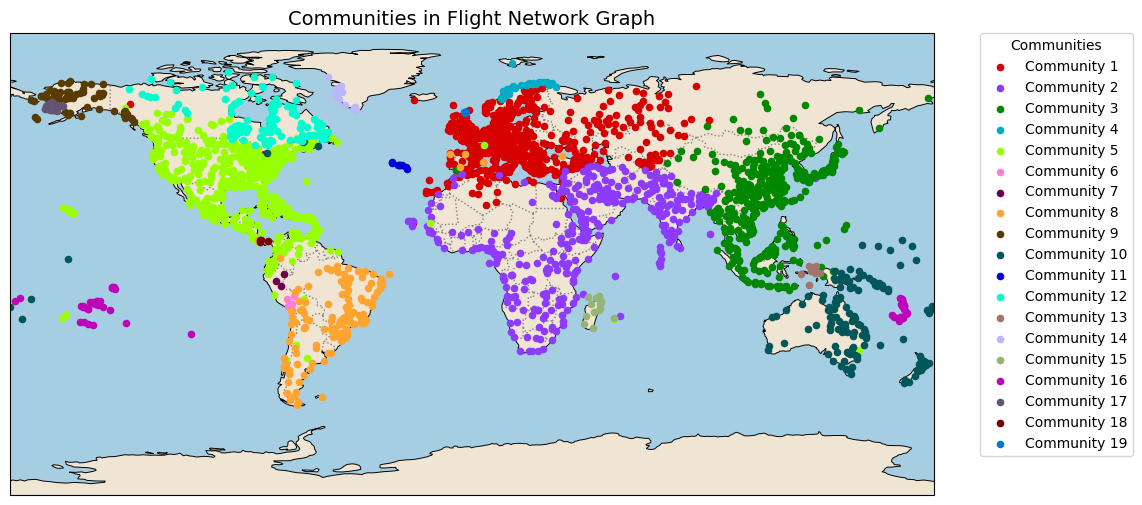

In [38]:
def graph_communities_visualization(graph1, community1):
    # Get the node positions
    positions = {node: data['coords'] for node, data in graph1.nodes(data=True)}

    # Set up the map using Cartopy
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Generate Glasbey palette
    num_communities1 = len(set(community1.values()))
    glasbey_palette = cc.glasbey[:num_communities1]

    # Enhanced map styling for the graph
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

    # Draw the graph with community-based node coloring
    for i, community in enumerate(set(community1.values())):
        nodes = [node for node, comm in community1.items() if comm == community]
        nx.draw_networkx_nodes(
            graph1,
            pos=positions,
            nodelist=nodes,
            node_color=[glasbey_palette[i]],
            node_size=20,
            ax=ax,
            label=f"Community {i + 1}"  # Label for the legend
        )

    # Add the legend
    ax.legend(
        title="Communities",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
        borderaxespad=0.
    )

    # Add a title
    ax.set_title("Communities in Flight Network Graph", fontsize=14)

    # Save and show the plot
    plt.savefig("communities_in_flight_network_graph.png", bbox_inches='tight')
    plt.show()

graph_communities_visualization(G_disperity, communities_disperity)


Based on the graph we can see that there are a few countires that form community like Norway and New Zeland. The rest of the communities is mostly formed based on the continent.

# Data scrapping and cleaning

For a more in-depth analysis, we included historical and demographic data for cities worldwide by scraping data from Wikipedia. Such involved getting relevant pages, extracting the necessary information and cleaning it. The code in each subsection goes into more detail when fetching Wikipedia content, as well as the extracting and cleaning of historical and demographic details to make our dataset richer.

### *Helper functions (Ana Marija, Ines)*

In [39]:
def get_wikipedia_page(name):
  """
  Fetch the Wikipedia page for a given city name using the Wikipedia API.
  Returns the raw JSON data from the query response.
  """

  baseurl = "https://en.wikipedia.org/w/api.php?"
  action = "action=query"
  urltitle = f"titles={name}" # City name to query
  content = "prop=revisions&rvprop=content&rvslots=main"
  dataformat ="format=json"

  query = f"{baseurl}{action}&{urltitle}&{content}&{dataformat}"

  # Send the query request to the Wikimedia API and get the response
  wikiresponse = urllib.request.urlopen(query)
  wikidata = wikiresponse.read()
  wikitext = wikidata.decode('utf-8')
  data = json.loads(wikitext)
  return data

def get_wikitext_content(data):
   """
    Extracts the content (wikicode) from the API response.
    Traverses the data structure to find and return the actual content.
    """
   if isinstance(data, dict):
      for key, value in data.items():
         if key == '*':
               return value
         result = get_wikitext_content(value)
         if result:
               return result
   elif isinstance(data, list):
      for item in data:
         result = get_wikitext_content(item)
         if result:
               return result
   return None

def clean_city_name (city_name):
  """
  Cleans the city name by replacing spaces with underscores and encoding it for URL use.
  """
  cleaned_name = str(city_name).replace(" ", "_") # Replace spaces with underscores
  cleaned_name = urllib.parse.quote(cleaned_name) # URL encode the city name
  return cleaned_name

def get_content(name):
  """
  Retrieves the content for a given city name by cleaning the name, fetching the Wikipedia page,
  and extracting the content.
  """
  city = clean_city_name(name) # Clean and prepare the city name
  data = get_wikipedia_page(city) # Get the page data
  content = get_wikitext_content(data) # Extract the content from the page data
  return content

def redirect (content):
  """
  This funciton redirect to the right page in case there is a need
  """
  if content is not None and "#REDIRECT" in content.upper():
    # get the redirect link
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    redirect_name = matches[0]
    content = get_content(redirect_name)

  return content

def may_refer_to_city(content):
  """
  In case there are more pages with the same name get the first one that matches either city or capital or town
  """
  if content is not None and len(content) < 6000 and ("may refer to" in content.lower() or "refers to" in content.lower()):
    matches = re.findall(r'\[\[(.*?)\]\](?=.*\b(capital|city|town)\b)', content)
    if len(matches) > 0:
      name = matches[0]
      content = get_content(name)
      content = redirect(content)
  return content

### *Fetching Wikipedia Content for Cities (Ana Marija, Ines)*
To scrape the data we use wikipedia API. While scraping we take into account that the redirect of the page. Also we have noticed that sometimes the page is not redirected but reather has a few links a user can click on to go to wanted page. In that case we take the first link that has capital or city or town in it.

In [79]:
# Running this code takes 20 minutes on colab and a LOT on perconal PC
not_found_content = []

output_dir = "./new_cities"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists

# Iterate through the nodes with a progress bar
for node in tqdm(G.nodes(), desc="Processing nodes", unit="node"):

    try:
        file_name = node + ".txt"
        output_file = os.path.join(output_dir, file_name)
        # Try to fetch the Wikipedia page and get the content
        content = get_content(node)

        # chech for redirect
        content = redirect(content)

        # chech to may refer to
        content = may_refer_to_city(content)

        # in case content is not found or is to small (it is assumed that in that case the conetent is irrelevant)
        if content is None or len(content) < 6000:
          not_found_content.append(node)
        else:
            with open(output_file, 'w', encoding='utf-8') as file:
                file.write(content)

    except Exception as e:
        not_found_content.append(node)
        # If an error occurs, print the error message and the node
        print(f"Failed to get content for node {node}: {e}")
        continue  # Continue to the next node if there's an error


Processing nodes: 100%|██████████| 3135/3135 [20:55<00:00,  2.50node/s]


In [80]:
print(len(not_found_content))

885


### *Extract and Clean History and Demography from the Wikipedia Scrapped Files (Ana Marija)*
To extract the History and Demography data we used regex. Due to the lack of data on the Demography/Demographics we have used the People sections as well as it also explains Demography of the city.
#### *Helper functions (Ana Marija)*

In [40]:
def find_history(wiki_content):
   # Search for a section titled "History" in the wiki content
   match = re.search(r'==\s*History\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return None

def find_demography(wiki_content):
   # Search for a section titled "Demography" in the wiki content
   match = re.search(r'==\s*Demography\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return find_demographics(wiki_content)

def find_demographics(wiki_content):
   # Search for a section titled "Demographics" in the wiki content
   match = re.search(r'==\s*Demographics\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return find_people(wiki_content)

def find_people(wiki_content):
   # Search for a section titled "Demographics" in the wiki content
   match = re.search(r'==\s*People\s*==([\s\S]*?)(?=\n==[^=]+==)', wiki_content)
   if match:
      history_text = match.group(1).strip()  # Extract the matched text and strip leading/trailing whitespace
      return history_text
   else:
      return None

def replace_links(match):
   """ Helper funciton for cleaning the wikipedia text"""
   if match.group(2):  # [[Text|OtherText]]
      return match.group(2)
   elif match.group(3):  # [[Text]]
      return match.group(3)
   return ""

def clean_text(text):
   """
   Use regular expressions to clean wikippedia text
   """
   # Remove all occurrences of the pattern [[File: ... ]] including any nested content inside
   text = re.sub(r'\[\[File:[^\[\]]*(?:\[\[[^\[\]]*\]\][^\[\]]*)*\]\]', '', text) # file remove, nested

   # Replace any occurrence of [[...]] with just the inner text (removes the brackets)
   text = re.sub(r"\[\[([^|\]]+)\|([^\]]+)\]\]|\[\[([^\]]+)\]\]", replace_links, text)

   # remove ref tags
   text = re.sub(r"<ref[^>/]*>.*?</ref>|<ref[^>]+/>", "", text)

   # remove tables
   text = re.sub(r"\{\|.*?\|\}", "", text, flags=re.DOTALL)

   # Remove any content wrapped in {{...}} (likely templates)
   text = re.sub(r'{{(.*?)}}', '', text, flags=re.DOTALL)

   # Remove any gallery tags <gallery>...</gallery>, typically used for images in wiki content
   text = re.sub(r'<gallery.*?>.*?</gallery>', '', text, flags=re.DOTALL)

   return text.strip()

### *Extract and Clean Historical and Demographical Content from Files (Ana Marija)*
To clean the history and demography we iterate througt every file in the new_cities folder (where the scraped data is saved).

In [43]:
# Specify source and destination directories
source_dir = 'new_cities/'
history_destination_dir = 'history/'
demography_destination_dir = 'demography/'

# Create the destination directory if it doesn't exist
os.makedirs(history_destination_dir, exist_ok=True)
os.makedirs(demography_destination_dir, exist_ok=True)

# Iterate over the files in the source directory
count_history = 0
count_demography = 0
for filename in os.listdir(source_dir):
   # define reading and writting paths
   source_path = os.path.join(source_dir, filename)
   history_destination_path = os.path.join(history_destination_dir, filename)
   demography_destination_path = os.path.join(demography_destination_dir, filename)

   # Check if it's a file (not a directory)
   if os.path.isfile(source_path):
      # Open the file in read mode and read its content
      with open(source_path, 'r', encoding='utf-8') as file:
         file_content = file.read()

      # extract histroy
      history = find_history(file_content)
      if history is not None:
         # clean the history
         history = clean_text(history)

         # count succesfull
         count_history += 1
         with open(history_destination_path, "w", encoding="utf-8") as file_history:
            file_history.write(history)

      # extract demography
      demography = find_demography(file_content)
      if demography is not None:
         # clean the demography
         demography = clean_text(demography)

         # count succesfull
         count_demography += 1
         with open(demography_destination_path, "w", encoding="utf-8") as file_demography:
            file_demography.write(demography)

   else:
      print(f"Skipped (not a file): {source_path}")

print("File transfer complete!")
print("Successfully extracted history:", count_history)
print("Successfully extracted demogrraphy:", count_demography)

File transfer complete!
Successfully extracted history: 1959
Successfully extracted demogrraphy: 1396


# Influence of population on the degree centrality and distribution

To address the research question, *"How does a city’s population influence the degree centrality and its distribution in a global flight network?"*, we integrated population data into our analysis. The main source of population information was the SimpleMaps World Cities Dataset. However, approximately 1,000 of the 3,000 nodes in the network lacked population data. To go around this issue, we manually extracted additional population information for around 50 nodes by parsing the before-mentioned scraped text files and utilizing regular expressions to identify and incorporate available *population_urban* data.

#### *Helper functions (Raquel)*

In [44]:
# Function to normalize city names
def normalize_city_name(city_name):
    # Replace common abbreviations like 'St' with 'Saint'
    city_name = re.sub(r'\bSt\b', 'Saint', city_name, flags=re.IGNORECASE)

    # Remove hyphens and other non-alphanumeric characters
    city_name = re.sub(r'[^a-zA-Z0-9]', '', city_name)

    # Remove accents and convert to lowercase
    city_name = unicodedata.normalize('NFKD', city_name).encode('ASCII', 'ignore').decode('ASCII')

    # Convert to lowercase to ensure case-insensitivity
    city_name = city_name.lower()

    return city_name

# Function to add population as integers to the graph
def add_population_to_graph(graph, city_df):
    # Ensure the DataFrame has no missing values in the matching column
    city_df = city_df[~city_df['city_ascii'].isnull()]

    # Normalize the graph node names (ensure the city names in the graph are also standardized)
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    # Iterate through the DataFrame
    for _, row in city_df.iterrows():
        city = row['city_ascii']
        population = row['population']

        # Normalize the city name
        normalized_city = normalize_city_name(city)

        # Convert population to integer if it is not null
        if not pd.isnull(population):
            population = int(population)

        # Check if the normalized city name exists in the graph nodes
        if normalized_city in normalized_nodes:
            # Add population as a node attribute
            nx.set_node_attributes(graph, {normalized_nodes[normalized_city]: {'population': population}})

    return graph

def check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path):
    # List to store cities that have corresponding files
    cities_with_files = []

    # Get all filenames in the directory (without the full path)
    city_files = os.listdir(city_files_path)

    # Lxoop through each city in missing_population_nodes
    for city in missing_population_nodes:
        # Normalize city name for filename search (optional step, depending on naming convention)
        normalized_city = normalize_city_name(city)

        # Create potential filenames based on the city name variations
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version (if filenames are unnormalized)
        ]

        # Check if any of the filenames exist in the directory
        for filename in filenames_to_check:
            if filename in city_files:
                cities_with_files.append(city)
                break  # If one of the filenames matches, no need to check further variations

    return cities_with_files

### *Get population from dataset (Raquel)*

In [45]:
G_population = nx.Graph(G)
df = pd.read_csv('worldcities.csv')
G_population = add_population_to_graph(G_population, df)
# List of nodes without population data
missing_population_nodes = [node for node, data in G_population.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

Number of nodes without population data: 1068


In [46]:
city_files_path = 'new_cities/'
# Check which cities have corresponding files in the new_cities folder
cities_with_files = check_missing_nodes_in_new_cities(missing_population_nodes, city_files_path)
print(cities_with_files)

['Minsk 2', 'Khudzhand', 'Fergana', 'Alma-ata', 'Mineralnye Vody', 'Aktau', 'Tel-aviv', 'Yakutia', 'Kurgan Tyube', 'Tselinograd', 'Kiev', 'Chimkent', 'Hurghada', 'Novy Urengoy', 'Navoi', 'Aktyubinsk', 'Heraklion', 'Rhodos', 'Duesseldorf', 'Milano', 'Enfidha', 'Kulyab', 'Bourgas', 'Andizhan', 'Termez', 'Urgench', 'Palma de Mallorca', 'Zaporozhye', 'Ulan Bator', 'Lvov', 'Ashkhabad', 'Ust Kamenogorsk', 'Dnepropetrovsk', 'Kharkov', 'Karaganda', 'Punta Cana', 'Ganja', 'Blagoveschensk', 'Sharm El Sheikh', 'Kostanay', 'Tambow', 'BRISTOL', 'Uraj', 'Bodaibo', 'Hailar', 'Chokurdah', 'Batagay-Alyta', 'Cuzco', 'Huánuco', 'Dallas-Fort Worth', 'Takoradi', 'Gran Canaria', 'Puerto Inírida', 'San Andres Island', 'Galapagos', 'Coca', 'Torino', 'Marsa Alam', 'Fuerteventura', 'Lamezia', 'Nuernberg', 'Luxemburg', 'Jersey', 'Djerba', 'Figari', 'Connaught', 'Guernsey', 'Hawarden', 'Menorca', 'Mykonos', 'East Midlands', 'El Aaiún', 'Hierro', 'Cardiff', 'Zweibruecken', 'Arvidsjaur', 'Gallivare', 'Joenkoeping',

### *Extract Population Data for Missing Cities from Scraped Files (Raquel)*

In [47]:
def normalize_city_name(city_name):
    # Add your own normalization logic, if needed (e.g., converting to lowercase, removing spaces)
    return city_name.strip().lower()

def extract_population_urban(content):
    # Updated regex to handle both commas and periods in population_urban values
    match = re.search(r'population_urban\s*=\s*([0-9.,]+)', content)
    if match:
        population_str = match.group(1)

        # Remove any non-numeric characters (like <ref>, whitespace, etc.)
        population_str = re.sub(r'[^\d.,]', '', population_str)

        # Replace period (.) as thousands separator (convert to commas)
        if '.' in population_str and ',' in population_str:
            population_str = population_str.replace('.', '')  # remove periods
        else:
            # If it only has periods and no commas, treat it as a thousands separator
            population_str = population_str.replace('.', '')

        # Now the population_str should contain only digits and commas
        # Remove commas, convert to integer
        population_str = population_str.replace(',', '')  # Remove commas for integer conversion

        try:
            return int(population_str)
        except ValueError:
            # If the conversion fails, return None (invalid format)
            return None
    return None

def check_population_urban_in_city_files(cities_with_files, city_files_path):
    city_population_urban = {}  # Dictionary to store city and corresponding population_urban

    for city in cities_with_files:
        # Normalize city name for filename search
        normalized_city = normalize_city_name(city)

        # Create potential filenames to check for the city
        filenames_to_check = [
            f"{normalized_city}.txt",  # Normalized version
            f"{city}.txt"              # Original name version
        ]

        # Check the files for population_urban
        found_population_urban = False

        for filename in filenames_to_check:
            file_path = os.path.join(city_files_path, filename)
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    content = file.read()

                    # Extract population_urban if present
                    population_urban = extract_population_urban(content)
                    if population_urban is not None:
                        city_population_urban[city] = population_urban
                        found_population_urban = True
                        break  # Once population_urban is found, no need to check further filenames

        if not found_population_urban:
          pass
            #print(f"Population urban data not found for {city}.")

    return city_population_urban  # Return the dictionary containing city and population_urban

def add_population_urban_to_graph(graph, city_population_urban):
    # Normalize all graph nodes to match city names
    normalized_nodes = {normalize_city_name(node): node for node in graph.nodes}

    for city, population_urban in city_population_urban.items():
        # Normalize the city name from the city_population_urban dictionary
        normalized_city = normalize_city_name(city)
        # Check if the normalized city name exists in the normalized nodes of the graph
        if normalized_city in normalized_nodes:
            original_node_name = normalized_nodes[normalized_city]

            # Add population_urban as a node attribute using the original (non-normalized) node name
            nx.set_node_attributes(graph, {original_node_name: {'population': population_urban}})

    return graph

In [48]:
city_population_urban = check_population_urban_in_city_files(cities_with_files, city_files_path)

if city_population_urban:
    G_population = add_population_urban_to_graph(G_population, city_population_urban)

In [49]:
# List of nodes without population data
missing_population_nodes = [node for node, data in G_population.nodes(data=True) if data.get('population') in (None, 0)]
print(f"Number of nodes without population data: {len(missing_population_nodes)}")

Number of nodes without population data: 1020


### *Population correlations (Raquel)*

To then explore the relationship between a city's population and its connectivity within the global flight network, we looked at how population size correlates with key network measures, such as degree centrality and edge weights, to further investigate the role of population in shaping global air travel patterns.

In [50]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)

# Create a list of nodes that have population data
nodes_with_population = [node for node, data in G_population.nodes(data=True) if 'population' in data]

# Now filter out centrality values only for nodes that have population data
filtered_degree_centrality = {node: degree_centrality[node] for node in nodes_with_population}

# Create a population list for the nodes with population data
filtered_population_values = [G_population.nodes[node]['population'] for node in nodes_with_population]

In [51]:
# Normalize population values using MinMaxScaler
scaler = MinMaxScaler()
normalized_population_values = scaler.fit_transform([[pop] for pop in filtered_population_values])

# Now, map back to the nodes
normalized_population_dict = dict(zip(nodes_with_population, normalized_population_values.flatten()))

In [52]:
# Filter out nodes where population or centrality is NaN or infinite
valid_nodes = [
    node for node in nodes_with_population
    if not np.isnan(normalized_population_dict[node]) and np.isfinite(normalized_population_dict[node])
    and not np.isnan(filtered_degree_centrality[node]) and np.isfinite(filtered_degree_centrality[node])
]

# Re-filter the centrality values and populations for valid nodes
filtered_population_values = [normalized_population_dict[node] for node in valid_nodes]
filtered_degree_values = [filtered_degree_centrality[node] for node in valid_nodes]
filtered_degree_values2 = [G.degree(node) for node in valid_nodes]  # Use raw degree instead of centrality

# Ensure all lists are of the same length (no missing values)
assert len(filtered_population_values) == len(filtered_degree_values)

In [53]:
# Get edge weights for the graph (assuming the graph has 'weight' attribute on edges)
edge_weights = {}
for node in valid_nodes:
    total_edge_weight = 0

    # Sum the weights of the edges connected to the node
    for neighbor in G_population.neighbors(node):
        if 'weight' in G_population[node][neighbor]:  # Check if weight attribute exists
            total_edge_weight += G[node][neighbor]['weight']

    # Store the total weight for the node
    edge_weights[node] = total_edge_weight

# List of edge weights corresponding to valid nodes
filtered_edge_weights = [edge_weights[node] for node in valid_nodes]

# Ensure no NaN or infinite values in edge weights and population data
filtered_population_values = [pop for pop, weight in zip(filtered_population_values, filtered_edge_weights) if not np.isnan(weight) and np.isfinite(weight)]
filtered_edge_weights = [weight for weight in filtered_edge_weights if not np.isnan(weight) and np.isfinite(weight)]

### *Calcuate correlation (Raquel)*

In [54]:
# Calculate Pearson correlation between population and centrality measures
degree_corr, _ = pearsonr(filtered_population_values, filtered_degree_values)
degree_corr2, _ = pearsonr(filtered_population_values, filtered_degree_values2)
edge_weight_corr, _ = pearsonr(filtered_population_values, filtered_edge_weights)

print(f"Correlation between population and degree centrality: {degree_corr}")
print(f"Correlation between population and degree: {degree_corr2}")
print(f"Correlation between population and sum of edge weights: {edge_weight_corr}")

Correlation between population and degree centrality: 0.40700581147085896
Correlation between population and degree: 0.4070058114708589
Correlation between population and sum of edge weights: 0.45528338331725243


### *Visualize correlation (Raquel)* 

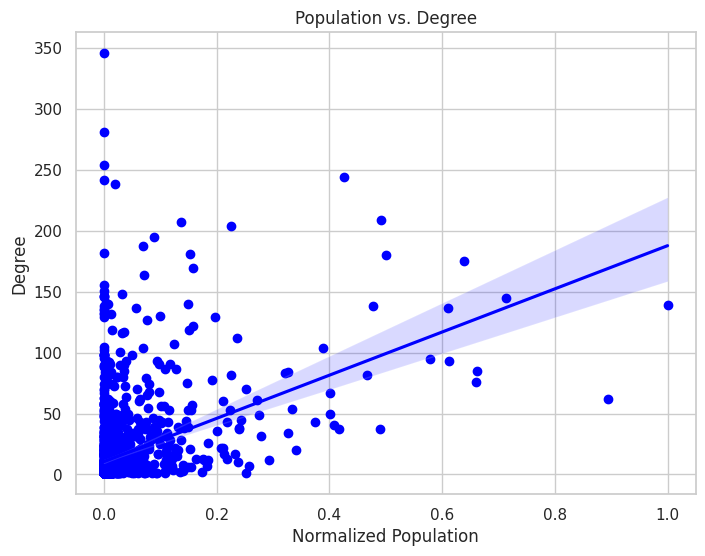

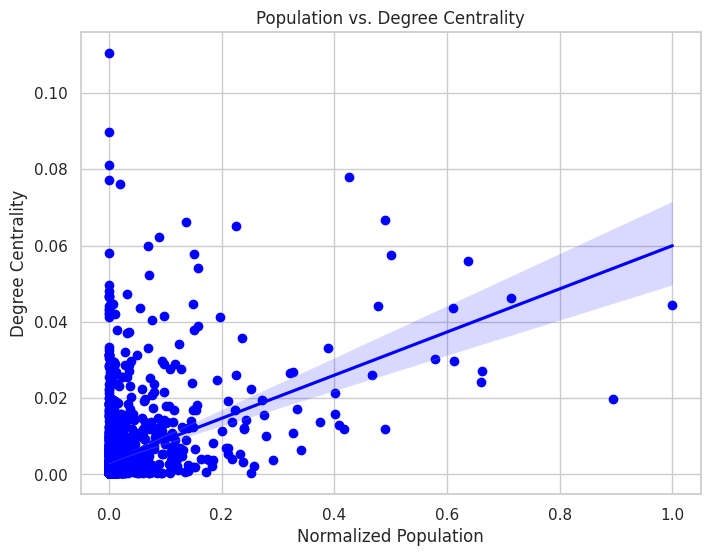

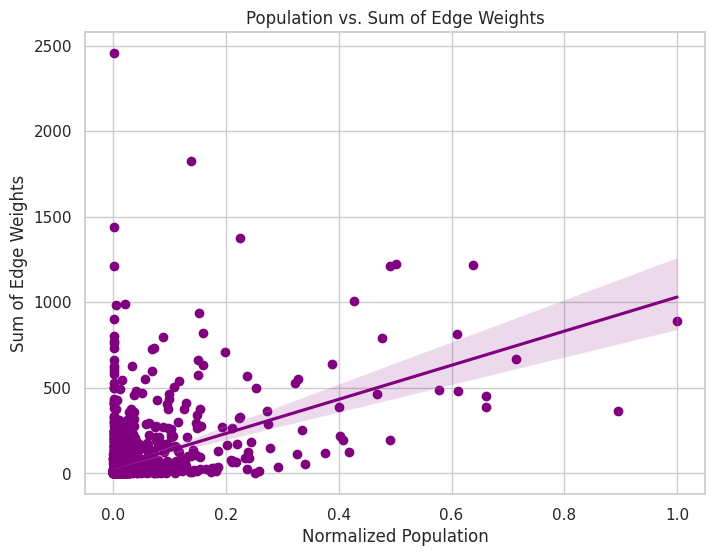

In [55]:
sns.set(style="whitegrid")

# Scatter plot for population vs. degree
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values2, color='blue', label='Degree')
sns.regplot(x=filtered_population_values, y=filtered_degree_values2, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree')
plt.title('Population vs. Degree')
plt.show()

# Scatter plot for population vs. degree centrality
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_degree_values, color='blue', label='Degree Centrality')
sns.regplot(x=filtered_population_values, y=filtered_degree_values, scatter=False, color='blue', line_kws={'color': 'blue'})
plt.xlabel('Normalized Population')
plt.ylabel('Degree Centrality')
plt.title('Population vs. Degree Centrality')
plt.show()

# Scatter plot for population vs. edge weights
plt.figure(figsize=(8, 6))
plt.scatter(filtered_population_values, filtered_edge_weights, color='purple', label='Edge Weights')
sns.regplot(x=filtered_population_values, y=filtered_edge_weights, scatter=False, color='purple', line_kws={'color': 'purple'})
plt.xlabel('Normalized Population')
plt.ylabel('Sum of Edge Weights')
plt.title('Population vs. Sum of Edge Weights')
plt.show()

With the results and visualizations above, we find that there is a slight positive correlation between population and network metrics.
Population vs. degree centrality had a Pearson coefficient of 0.4067, while population vs. sum of edge weights showed 0.4551, highlighting that larger cities tend to have more connections and handle higher flight frequencies.

# Calculate similarty between cities based on the history and demography text

### *Combining Historical and Demographic Text for Graph Creation (Ines)*

With the history and demographic of each city now scraped, in the below we try to associate the mentioned content with cities in the graph, which is then combined into a single data frame. By linking the text for each city´s nodes, we link the city to its combined historical and demographic information for further analysis.

In [ ]:
# Initialize an empty DataFrame with the required columns and explicit types
text_df = pl.DataFrame({
    "node": pl.Series([], dtype=pl.Utf8),
    "combined_text": pl.Series([], dtype=pl.Utf8)
})

history_folder = 'history'
# Process files in the `history` folder
for filename in os.listdir(history_folder):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G.nodes():
      with open(os.path.join(history_folder, filename), 'r', encoding='utf-8') as file:
          content = file.read()
      new_row = pl.DataFrame({"node": [filename_wo_txt], "combined_text": [content]})
      text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

demography_folder = 'demography'
# Process files in the `demography` folder
for filename in os.listdir(demography_folder):
    filename_wo_txt = os.path.splitext(filename)[0]
    if filename_wo_txt in G.nodes():
        with open(os.path.join(demography_folder, filename), 'r', encoding='utf-8') as file:
            content = file.read()
        new_row = pl.DataFrame({"node": [filename_wo_txt], "combined_text": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)

# Combine rows for the same `node` into a single row with concatenated text
nodes = text_df["node"].unique()
aggregated_data = []

for node in nodes:
    node_data = text_df.filter(text_df["node"] == node)
    combined_text = " ".join(node_data["combined_text"].drop_nulls().to_list())
    aggregated_data.append({"node": node, "combined_text": combined_text})

# Create the final DataFrame
text_df = pl.DataFrame(aggregated_data)

### *Create Flight netowrk subgraph with nodes that have history or demography Content (Ines, Ana Marija)*

In this section, we create a subgraph of the global flight network by removing the cities that do not have historical or demographic data. It filters the graph to keep only the cities present in `text_df`, this results in a subgraph that includes only the cities with relevant text content.

In [61]:
cities = text_df['node'].to_list()

G_flights_sub = G.copy()
print("Before creating subgraph")
print(G)

# List to store nodes to remove
nodes_to_remove = []

for node in G_flights_sub.nodes():
    if node not in cities:
        nodes_to_remove.append(node)

# Remove nodes that do not have history
G_flights_sub.remove_nodes_from(nodes_to_remove)
print("After creating subgraph")
print(G_flights_sub)

Before creating subgraph
Graph with 3135 nodes and 17694 edges
After creating subgraph
Graph with 2062 nodes and 12841 edges


In [37]:
with open('G_flights_sub.pickle', 'wb') as f:
    pickle.dump(G_flights_sub, f)

### *Prepare Data for Text Analysis (Ines)*
Here we quickly process the historical and demographic text data for each city. By tokenizing the text, converting it to lowercase, removing the punctuation, lemmatizing the words, filtering out stopwords, and removing single-character words, we end up with cleaned and processed tokens for each city. Such is stored in the city_history_dict dictionary, where the key is the city's name and the value is the processed text.

In [62]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# get all the tokens that refer to the same genre
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#stop_words.update(['http','title', 'short', 'description', ' ', 'wa'])

city_history_dict = {}
for row in text_df.iter_rows(named=True):
    city = row["node"]
    city_text = row["combined_text"]

    # Tokenize text
    tokens = word_tokenize(city_text)
    # Convert to lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Remove single characters
    tokens = [word for word in tokens if len(word) > 1]

    content = " ".join(tokens)
    city_history_dict[city] = content

[nltk_data] Downloading package punkt to
[nltk_data]     /zhome/ab/b/202560/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /zhome/ab/b/202560/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /zhome/ab/b/202560/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /zhome/ab/b/202560/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### *City Text Analysis with TF-IDF and Cosine Similarity (Ines)*

With the processed text from above, this section analyzes city history text using TF-IDF and cosine similarity. TF-IDF converts the text into numerical values, highlighting the most important terms in each city's history. Then cosine similarity measures how similar each city's content is to the rest.

In [63]:
# Calculate TF-IDF for each genre
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(city_history_dict.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

In [64]:
# Extract the list of cities (nodes) from the 'node' column in the history_df dataframe
cities = text_df['node'].to_list()

# Compute the cosine similarity matrix for the TF-IDF matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

# Create a dataframe to store the cosine similarities
cosine_similarities_tfidf = pd.DataFrame(cosine_sim_matrix, index=cities, columns=cities)

In [65]:
print("Mean: ", cosine_similarities_tfidf.mean().mean())
'''print(f'{cosine_similarities_dslim.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_dslim.mean().max()}')
print(f'{cosine_similarities_dslim.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_dslim.mean().min()}')
'''
print("Max: ", cosine_similarities_tfidf.mean().max())
print("Min: ", cosine_similarities_tfidf.mean().min())
print("Median: ", cosine_similarities_tfidf.mean().median())
print("Std: ", cosine_similarities_tfidf.mean().std())

Mean:  0.03282521074892384
Max:  0.08976220988450175
Min:  0.0
Median:  0.03157359886493562
Std:  0.012437489943354285


Due to the results being so poorly distibuted we decided to try with LDA.

### *City Text Analysis with LDA and Cosine Similarity (Ines)*

Following the same logic as before, here we use LDA to analyze city history text, extracting 10 topics from it. Cosine similarity is then computed based on these topics to compare cities. Key statistics like mean, max, and min similarities are also calculated.

In [66]:
# Find number of subsections in text file
def find_all_sections(wiki_content):
    # Match any section with = signs and its content
    pattern = r'(={2,}\s*[^=\n]+\s*={2,})([\s\S]*?)(?=\n={2,}[^=]+=*|\Z)'
    matches = re.findall(pattern, wiki_content)

    # Extract section headers and their content into a dictionary
    sections = {}
    for header, content in matches:
        # Clean the header of excess = signs and whitespace
        clean_header = re.sub(r'^={2,}\s*|\s*={2,}$', '', header).strip()
        sections[clean_header] = content.strip()

    return sections

In [67]:
sub_sections = {}
# Get subsection count of each city
for city in cities:
    text = " ".join(text_df.filter(text_df["node"] == city)["combined_text"].to_list())
    sections = find_all_sections(text)
    sub_sections[city] = len(sections)

# Get mean
mean_sub_sections = round(sum(sub_sections.values()) / len(sub_sections))
print(f"Mean number of subsections per city: {mean_sub_sections}")

Mean number of subsections per city: 3


In [68]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Apply the vectorizer to the city history text data to create a term frequency matrix
tf = vectorizer.fit_transform(city_history_dict.values())

# Initialize the Latent Dirichlet Allocation (LDA) model to extract 10 topics
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tf)

topics = lda.components_  # Word distributions per topic

# Transform the term frequency matrix to get the topic distribution for each city
city_topics_matrix = lda.transform(tf)

### *Calcualte similarties between cities (Ines)*

In [69]:
# Compute cosine_similarity for LDA
cosine_similarities_lda = cosine_similarity(city_topics_matrix)
cosine_similarities_lda = pd.DataFrame(cosine_similarities_lda, index=cities, columns=cities)

In [70]:
print("Mean: ", cosine_similarities_lda.mean().mean())
print(f'{cosine_similarities_lda.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_lda.mean().max()}')
print(f'{cosine_similarities_lda.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_lda.mean().min()}')
# Get the two cities with the highest similarities besides their own

print("Max: ", cosine_similarities_lda.mean().max())
print("Min: ", cosine_similarities_lda.mean().min())
print("Median: ", cosine_similarities_lda.mean().median())
print("Std: ", cosine_similarities_lda.mean().std())

Mean:  0.23328396706600432
Inhambane is the city with the most similarities with an average of 0.4349838392138181
Armenia is the city with the least similarities with an average of 0.06576561089431376
Max:  0.4349838392138181
Min:  0.06576561089431376
Median:  0.26639800454786927
Std:  0.07598363460553974


Seeing as those results are more distributed then the TF-IDF one we have dicided to use those similarities in our graph comparison.

# Comparions between flight network graph and graphs based on similarities between the cities

### *Create Fully connected graph (Ana Marija)*

In [76]:
G_full = nx.Graph()
G_full.add_nodes_from(G_flights_sub.nodes(data=True))
print(f"Number of nodes in the graph: {len(G_full.nodes())}")

for city1 in cosine_similarities_lda.index:
   for city2 in cosine_similarities_lda.columns:
      if city1 != city2:  # Exclude self-loops
         weight = cosine_similarities_lda.loc[city1, city2]
         G_full.add_edge(city1, city2, weight=weight)
print(G_full)

Number of nodes in the graph: 2062
Graph with 2062 nodes and 2124891 edges


### *Filter graph with disperity filter (Ana Marija)*
Note: DO NOT RUN IT IF YOU WANT TO KEEP YOUR SANITY

In [ ]:
G_disparity_full = G_full.copy()

alpha_measures = disparity_filter(G_disparity_full)
print("Alpha measures calculated:", alpha_measures)

quantiles = calc_quantiles(alpha_measures, num = 10)

# Determine alpha cutoff (median, 30th percentile)
min_alpha_ptile = 0.95
alpha_cutoff = quantiles[int(min_alpha_ptile * (len(quantiles) - 1))]
print(f"Using alpha cutoff at {min_alpha_ptile * 100}% percentile: {alpha_cutoff}")

# Filter the graph based on the cutoff
cut_graph(G_disparity_full, min_alpha_ptile=min_alpha_ptile)

print(f"There were {len(G_full.nodes())} nodes and {len(G_full.edges())} edges in un-filtered graph")
print(f"There are currently {len(G_disparity_full.nodes())} nodes and {len(G_disparity_full.edges())} edges in filtered graph")

This code took too long to run, and even the DTU HPC resurces were not enougth for it duo to the 24h time limit.

### *Create Similarity graph with the same edges per node (Ines)*

This section builds a graph where edges represent LDA cosine similarities between cities. Cities are connected based on their historical content, and the number of edges matches the flight subgraph's degree. Each node includes the top 100 words and 10 topics. The final graph is saved as a pickle file.

In [71]:
G_hist = nx.Graph()
G_hist.add_nodes_from(G_flights_sub.nodes(data=True))
print(f"Number of nodes in the graph: {len(G_hist.nodes())}")

Number of nodes in the graph: 2062


In [80]:
# Get the number of edges in each node in G_text
num_edges = dict(G_flights_sub.degree())

# Add same number of edges between cities in G_hist as in G_text
for city in cities:
    if num_edges[city] > 0:
        num_edges_city = num_edges[city]
        top_similarities = cosine_similarities_lda[city].sort_values(ascending=False)[:num_edges_city]
        for similar_city in top_similarities.index:
            if similar_city != city:
                G_hist.add_edge(city, similar_city, weight=top_similarities[similar_city])
                
print("Similarity graph with the same edges per node:", G_hist)


Similarity graph with the same edges per node:  Graph with 2062 nodes and 21232 edges


In [81]:
# Add top 100 words to each node
len_of_city = len(cities)
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    top_words = [feature_names[i] for i in top_word_indices]
    G_hist.nodes[city]['top_words'] = top_words

# Add top 3 topics to each node
for i, city in enumerate(cities):
    city_topic = city_topics_matrix[i]  # Access the topic distribution for this city (row i)
    top_topics = city_topic.argsort()[-3:][::-1]  # Get the indices of the top 3 topics
    G_hist.nodes[city]['top_topics'] = top_topics


In [ ]:
# Save as pickle
with open('graph_with_history_lda_1.pickle', 'wb') as f:
   pickle.dump(G_hist, f)

In [ ]:
with open('/content/drive/MyDrive/graph_with_history_lda_1.pickle', 'rb') as f:
    G_hist = pickle.load(f)

In [82]:
print("Nodes ", len(G_hist.nodes()))
print("Edges ", len(G_hist.edges()))

Nodes  2062
Edges  21232


### *Create Similarity graph with the same number of edges as Flight connections subgraph (Ana Marija)*

In this section, we construct a graph based on LDA topic similarities, ensuring the number of edges matches the subgraph of flight routes. We start by identifying the top city pairs with the highest similarities, then create a graph where these pairs are connected by edges weighted by their similarity. 


After removing isolated nodes, we visualize the core component of the graph on a map, showcasing the connections between cities based on their historical and demographic similarities.

In [84]:
number_of_edges = len(list(G_flights_sub.edges()))

# Get the upper triangle and similarities
upper_triangle = np.triu_indices_from(cosine_similarities_lda.values, k=1)
similarities = cosine_similarities_lda.values[upper_triangle]

# Get the top similarittes
top_similarities = np.argsort(similarities)[::-1][:number_of_edges]

rows, cols = upper_triangle
top_pairs = pd.DataFrame({
    "City1": cosine_similarities_lda.index[rows[top_similarities]],
    "City2": cosine_similarities_lda.columns[cols[top_similarities]],
    "Similarity": similarities[top_similarities]
})


G_lda_ana = nx.Graph()
G_lda_ana.add_nodes_from(G_flights_sub.nodes(data=True))

for _, row in top_pairs.iterrows():
   G_lda_ana.add_edge(row["City1"], row["City2"], weight=row["Similarity"])

print(G_lda_ana)


Graph with 2062 nodes and 12841 edges


### *Remove isolated nodes from Flight connections subgraph and Similarity graph with the same number of edges (Ana Marija)*

In [86]:
G_flights_sub_isloated = G_flights_sub.copy()
isolated_nodes_flights = list(nx.isolates(G_flights_sub_isloated))
G_flights_sub_isloated.remove_nodes_from(isolated_nodes_flights)

G_lda_ana_isolated = G_lda_ana.copy()
isolated_nodes_lda = list(nx.isolates(G_lda_ana_isolated))
G_lda_ana_isolated.remove_nodes_from(isolated_nodes_lda)


print("Before removing isolated nodes")
print(f'G_flights: {G_flights_sub.number_of_nodes()} nodes, {G_flights_sub.number_of_edges()} edges')
print(f'G_lda: {G_lda_ana.number_of_nodes()} nodes, {G_lda_ana.number_of_edges()} edges')
print("After removing isolated nodes")
print(f'G_flights: {G_flights_sub_isloated.number_of_nodes()} nodes, {G_flights_sub_isloated.number_of_edges()} edges')
print(f'G_lda: {G_lda_ana_isolated.number_of_nodes()} nodes, {G_lda_ana_isolated.number_of_edges()} edges')

Before removing isolated nodes
G_flights: 2062 nodes, 12841 edges
G_lda: 2062 nodes, 12841 edges
After removing isolated nodes
G_flights: 2003 nodes, 12841 edges
G_lda: 478 nodes, 12841 edges


### *Plot Similarity graph with the same number of edges after romoving isolated nodes (Ana Marija, Ines)*

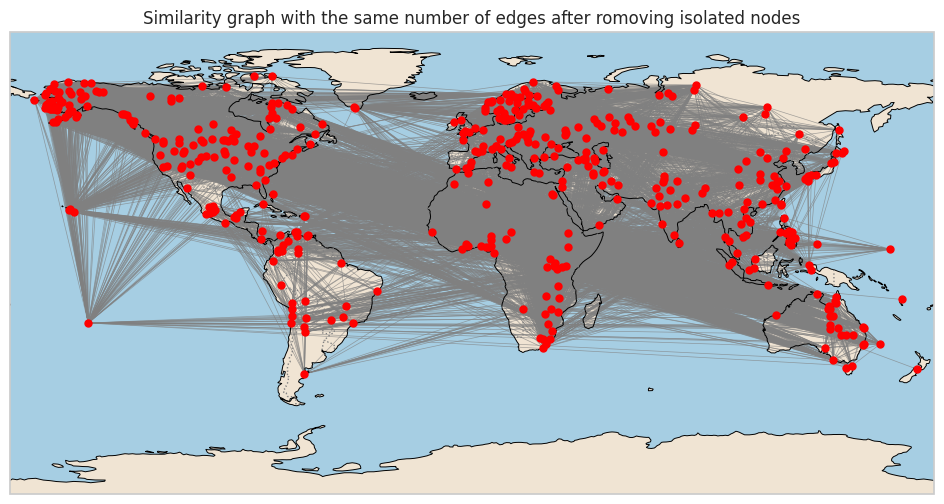

In [92]:
positions = {node: data['coords'] for node, data in G_lda_ana_isolated.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

# Draw the graph
nx.draw_networkx_edges(G_lda_ana_isolated, positions, ax=ax, edge_color='gray', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G_lda_ana_isolated, positions, ax=ax, node_size=25, node_color='red')

plt.title("Similarity graph with the same number of edges after romoving isolated nodes")
plt.show()

We can see that the most nodes that are left are located in Europe and North America. It makes sense as there is a lot of hisotry and demography similaarty among those cities.

In [ ]:
cities = list(G_lda_ana.nodes())
len_of_city = len(cities)
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    top_words = [feature_names[i] for i in top_word_indices]
    G_lda_ana.nodes[city]['top_words'] = top_words

### *Graph Comparision between Similarity graph with the same edges per node and Flight connections subgraph (Ines)*

The below code involves evaluating structural similarities using metrics like community detection, cut distance, and Jaccard similarity. These methods help highlight similarities, giving a comprehensive comparison of graph-based networks.

### *Helper functions (Ana Marija, Ines)*

In [93]:
def cut_weight(graph, S, T):
    """
    Calculate the cut weight for an undirected, weighted graph.
    Parameters:
        graph: A NetworkX graph (undirected/weighted).
        S: A set of nodes.
        T: The complementary set of nodes.
    Returns:
        Cut weight: Total weight of edges crossing from S to T.
    """
    cut_wt = 0
    for u, v in graph.edges():
        if (u in S and v in T) or (u in T and v in S):
            cut_wt += graph[u][v].get('weight', 1)
    return cut_wt

def cut_distance(graph1, graph2, num_samples=100):
    """
    Approximate the cut distance between two undirected, weighted graphs.
    Parameters:
        graph1, graph2: Two NetworkX graphs with the same node set.
        num_samples: Number of random partitions to approximate the maximum.
    Returns:
        Approximate cut distance between the graphs.
    """
    # Ensure both graphs have the same set of nodes
    if set(graph1.nodes()) != set(graph2.nodes()):
        raise ValueError("Graphs must have the same node set.")

    nodes = list(graph1.nodes())
    n = len(nodes)
    max_diff = 0

    # Generate random bipartitions for approximation
    for _ in range(num_samples):
        np.random.shuffle(nodes)
        split = n // 2
        S = set(nodes[:split])
        T = set(nodes[split:])

        # Calculate cut weights for both graphs
        cut1 = cut_weight(graph1, S, T)
        cut2 = cut_weight(graph2, S, T)

        # Update the maximum difference
        max_diff = max(max_diff, abs(cut1 - cut2))

    # Normalize by the number of nodes for scale invariance
    return max_diff / n

def jaccard_similarity_across_graphs(G1, G2, node):
    # Get the neighbors of the node in both graphs
    neighbors1 = set(G1.neighbors(node))
    neighbors2 = set(G2.neighbors(node))

    # Calculate the intersection and union
    intersection = len(neighbors1 & neighbors2)
    union = len(neighbors1 | neighbors2)

    # Jaccard similarity formula
    if union == 0:  # Handle case where both sets of neighbors are empty
        return 0.0
    else:
        return intersection / union

def jaccard_similarity_edges(graph1, graph2):
   # Get the sets of edges for each graph
   edges1 = set(graph1.edges())
   edges2 = set(graph2.edges())

   # Compute intersection and union of the edge sets
   intersection = edges1 & edges2
   union = edges1 | edges2

   # Compute Jaccard similarity
   jaccard_sim = len(intersection) / len(union) if len(union) > 0 else 0.0

   print(f"Number of edges in Graph 1: {len(edges1)}")
   print(f"Number of edges in Graph 2: {len(edges2)}")
   print(f"Number of common edges: {len(intersection)}")
   print(f"Number of total unique edges: {len(union)}")
   print(f"Jaccard Similarity: {jaccard_sim:.3f}")

   return jaccard_sim

def weighted_jaccard(g1, g2):
    neighbors1 = set(g1.neighbors(node))
    neighbors2 = set(g2.neighbors(node))
    intersection = neighbors1 & neighbors2
    union = neighbors1 | neighbors2
    mins, maxs = 0, 0
    mins, maxs = 0, 0
    for neighbor in intersection:
        weight1 = g1.get_edge_data(node, neighbor, {}).get('weight', 0)
        weight2 = g2.get_edge_data(node, neighbor, {}).get('weight', 0)
        mins += min(weight1, weight2)

    for neighbor in union:
        weight1 = g1.get_edge_data(node, neighbor, {}).get('weight', 0)
        weight2 = g2.get_edge_data(node, neighbor, {}).get('weight', 0)
        maxs += max(weight1, weight2)
    if maxs == 0:
        return 0
    return mins / maxs

# 1. Compare Nodes
def compare_nodes(graph1, graph2):
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1 & nodes2
    print(f"Nodes in both graphs: {len(common_nodes)}")
    print(f"Nodes only in Graph 1: {len(nodes1 - nodes2)}")
    print(f"Nodes only in Graph 2: {len(nodes2 - nodes1)}")
    return common_nodes

def compute_node_centrality(graph, centrality_type='degree'):
    if centrality_type == 'degree':
        return nx.degree_centrality(graph)
    elif centrality_type == 'closeness':
        return nx.closeness_centrality(graph)
    elif centrality_type == 'betweenness':
        return nx.betweenness_centrality(graph)
    else:
        raise ValueError("Invalid centrality type")

def compare_edge_weights(graph1, graph2):
    common_edges = set(graph1.edges()) & set(graph2.edges())

    if len(common_edges) < 2:
        print(f"Not enough common edges to calculate correlation. Found {len(common_edges)} common edges.")
        return None, None

    weights1 = np.array([graph1[u][v]['weight'] for u, v in common_edges])
    weights2 = np.array([graph2[u][v]['weight'] for u, v in common_edges])

    # Normalize the weights to a range of 0 to 1
    scaler = MinMaxScaler()
    weights1 = scaler.fit_transform(weights1.reshape(-1, 1)).flatten()
    weights2 = scaler.fit_transform(weights2.reshape(-1, 1)).flatten()

    # Calculate correlations
    corr_pearson = pearsonr(weights1, weights2)
    corr_spearman = spearmanr(weights1, weights2)

    print(f"Edge Weight Correlation (Pearson): {corr_pearson[0]:.3f}")
    print(f"Edge Weight Correlation (Spearman): {corr_spearman[0]:.3f}")

    return corr_pearson, corr_spearman

def compute_graph_metrics(graph):
    avg_path_length = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else None
    clustering_coefficient = nx.average_clustering(graph)
    graph_diameter = nx.diameter(graph) if nx.is_connected(graph) else None
    print(f"Average Path Length: {avg_path_length}")
    print(f"Clustering Coefficient: {clustering_coefficient}")
    print(f"Graph Diameter: {graph_diameter}")

def compare_weighted_graphs(graph1, graph2):
    # Get the union of edges from both graphs
    edges_union = set(graph1.edges()) | set(graph2.edges())

    # Normalize weights across both graphs
    all_weights = []
    for edge in edges_union:
        w1 = graph1[edge[0]][edge[1]].get('weight', 0) if graph1.has_edge(*edge) else 0
        w2 = graph2[edge[0]][edge[1]].get('weight', 0) if graph2.has_edge(*edge) else 0
        all_weights.append((w1, w2))

    # Convert weights to numpy array for normalization
    weights_array = np.array(all_weights)
    scaler = MinMaxScaler()
    normalized_weights = scaler.fit_transform(weights_array)

    # Split normalized weights into two arrays
    weights1 = normalized_weights[:, 0]
    weights2 = normalized_weights[:, 1]

    # Calculate distances
    euclidean_dist = euclidean(weights1, weights2)
    manhattan_dist = cityblock(weights1, weights2)
    canberra_dist = canberra(weights1, weights2)

    # Calculate Jaccard distance based on edge presence
    edges_graph1 = set(graph1.edges())
    edges_graph2 = set(graph2.edges())
    intersection = len(edges_graph1 & edges_graph2)
    union = len(edges_graph1 | edges_graph2)
    jaccard_dist = 1 - intersection / union if union > 0 else 1  # 1 if no union

    # Print results
    print(f"Euclidean Distance (EUC): {euclidean_dist:.4f}")
    print(f"Manhattan Distance (MAN): {manhattan_dist:.4f}")
    print(f"Canberra Distance (CAN): {canberra_dist:.4f}")
    print(f"Jaccard Distance (JAC): {jaccard_dist:.4f}")

def graph_vis_comparison(graph1, graph2, community1, community2):

    positions = {node: data['coords'] for node, data in graph1.nodes(data=True)}
    positions = positions | {node: data['coords'] for node, data in graph2.nodes(data=True)}

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

    # Generate Glasbey palette
    num_communities1 = len(set(community1.values()))
    num_communities2 = len(set(community2.values()))
    num_colors = max(num_communities1, num_communities2)
    glasbey_palette = cc.glasbey[:num_colors]

    # Enhanced map styling for the first graph
    ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax1.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax1.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")


    # Draw the first graph
    for i, community in enumerate(set(community1.values())):
        nodes = [node for node in community1 if community1[node] == community]
        nx.draw_networkx_nodes(graph1, pos=positions, nodelist=nodes, node_color=[glasbey_palette[i]], node_size=20, ax=ax1)
    ax1.set_title("Graph 1")

    # Enhanced map styling for the second graph
    ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax2.add_feature(cfeature.LAND, facecolor="#f0e4d3")
    ax2.add_feature(cfeature.OCEAN, facecolor="#a6cee3")
    ax2.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
    ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")

    # Draw the second graph
    for i, community in enumerate(set(community2.values())):
        nodes = [node for node in community2 if community2[node] == community]
        nx.draw_networkx_nodes(graph2, pos=positions, nodelist=nodes, node_color=[glasbey_palette[i]], node_size=20, ax=ax2)

    ax2.set_title("Graph 2")
    ax2.legend

    plt.show()

### Detect Communities

In [99]:
print("Communities in Flight connections subgraph:")
communities_airlines = detect_communities(G_flights_sub)
compute_modularity(G_flights_sub, communities_airlines)

print("Communities in Flight connections subgraph without isolated nodes")
communities_airlines_isloated = detect_communities(G_flights_sub_isloated)
compute_modularity(G_flights_sub_isloated, communities_airlines_isloated)

print("Communities in Similarity graph with the same edges per node:")
communities_similarity_ines = detect_communities(G_hist)
compute_modularity(G_hist, communities_similarity_ines)

print("Communities in Similarity graph with the same number of edges without isolated nodes:")
communities_similarity_ana = detect_communities(G_lda_ana_isolated)
compute_modularity(G_lda_ana_isolated, communities_similarity_ana)

Communities in Flight connections subgraph:
Detected 93 communities
Modularity of the graph: 0.6262
Communities in Flight connections subgraph without isolated nodes
Detected 33 communities
Modularity of the graph: 0.6260
Communities in Similarity graph with the same edges per node:
Detected 33 communities
Modularity of the graph: 0.8051
Communities in Similarity graph with the same number of edges without isolated nodes:
Detected 42 communities
Modularity of the graph: 0.5611


One of the interesting observations is that the Flight connections subgraph without isolated nodes and Similarity graph with the same edges per node have the same number of communities, but the modularity in the Similarity graph with the same edges per node is significantly higer.

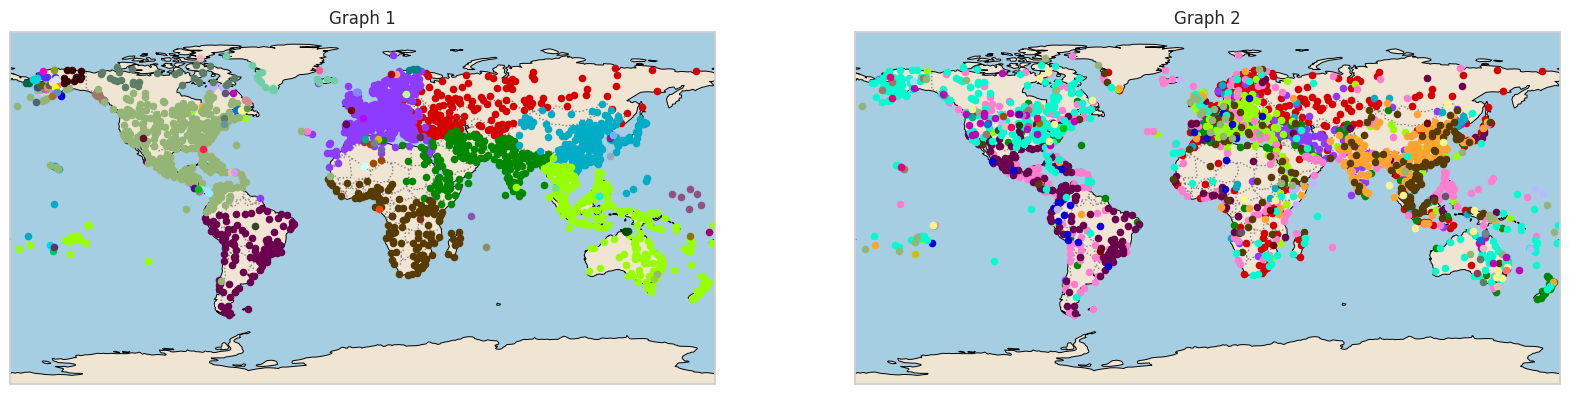

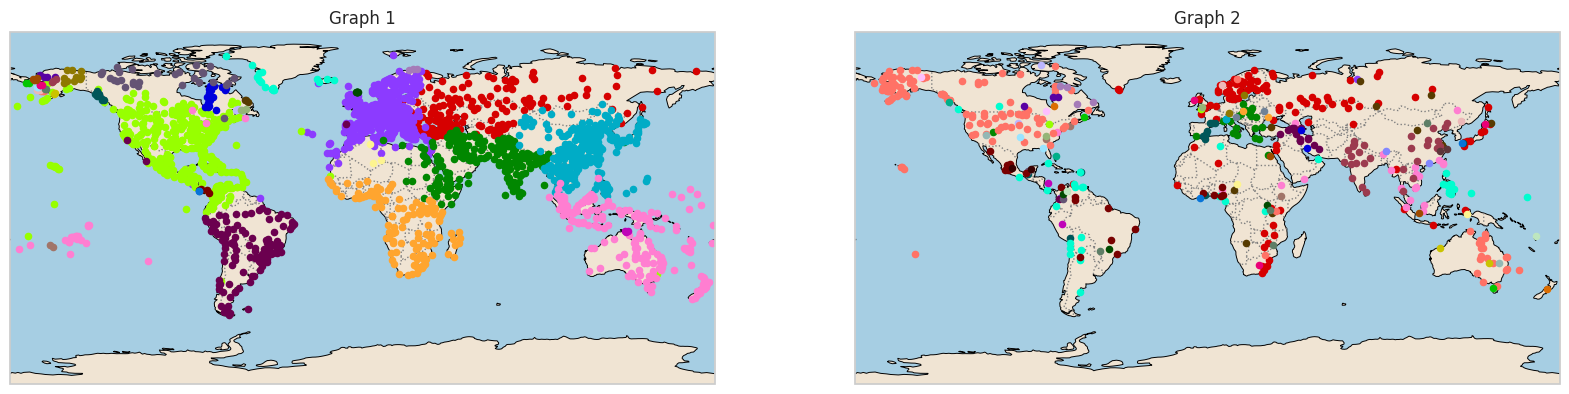

In [97]:
graph_vis_comparison(G_flights_sub, G_hist, communities_airlines, communities_similarity_ines)
graph_vis_comparison(G_flights_sub_isloated, G_lda_ana_isolated, communities_airlines_isloated, communities_similarity_ana)

After removing isolated nodes from Flight connections subgraph we can notice that the number of communities is similar to the Flight network graph filtered with disperity filter.

### *Calcualte Average Community Nodes in Flight connections subgraph, Similarity graph with the same edges per node, Similarity graph with the same number of edges without isolated nodes (Ana Marija, Ines)*

In [101]:
def get_community_node_counts(community):
    community_sizes = Counter(community.values())
    community_node_counts = {community: [] for community in community_sizes.keys()}
    for node, community_id in community.items():
        community_node_counts[community_id].append(node)
    return community_node_counts

def get_top_communities(community, num_communities):
    #community_sizes = get_community_node_counts(community)
    #top_communities = community_sizes.most_common(num_communities)
    community_sizes = Counter(community.values())
    top_communities = community_sizes.most_common(num_communities)
    return top_communities

top_communities_airlines = get_top_communities(communities_airlines, 5)
print("Top 5 communities in the Airline Graph:", top_communities_airlines)
top_communities_similarity = get_top_communities(communities_similarity_ines, 5)
print("Top 5 communities in the Similarity Graph:", top_communities_similarity)
top_communities_ana = get_top_communities(communities_similarity_ana, 5)
print("Top 5 communities in the Similarity Graph:", top_communities_ana)

# Get average node count for each community
community_node_counts_airlines = get_community_node_counts(communities_airlines)
mean_airlines = sum(len(nodes) for nodes in community_node_counts_airlines.values()) / len(community_node_counts_airlines)
print("Average Community Node Count in the Airline Graph:", mean_airlines)

community_node_counts_similarity = get_community_node_counts(communities_similarity_ines)
mean_similarity = sum(len(nodes) for nodes in community_node_counts_similarity.values()) / len(community_node_counts_similarity)
print("Average Community Node Count in the Similarity Graph:", mean_similarity)

community_node_counts_ana = get_community_node_counts(communities_similarity_ana)
mean_ana = sum(len(nodes) for nodes in community_node_counts_ana.values()) / len(community_node_counts_ana)
print("Average Community Node Count in the Similarity Graph:", mean_ana)

Top 5 communities in the Airline Graph: [(1, 399), (4, 394), (3, 263), (2, 229), (5, 206)]
Top 5 communities in the Similarity Graph: [(13, 341), (6, 273), (1, 253), (2, 197), (5, 197)]
Top 5 communities in the Similarity Graph: [(22, 136), (0, 105), (11, 38), (31, 29), (2, 21)]
Average Community Node Count in the Airline Graph: 22.172043010752688
Average Community Node Count in the Similarity Graph: 62.484848484848484
Average Community Node Count in the Similarity Graph: 11.380952380952381


### *Plot top 100 words for top 2 communities in the Similarity graph with the same edges per node (Ines)*

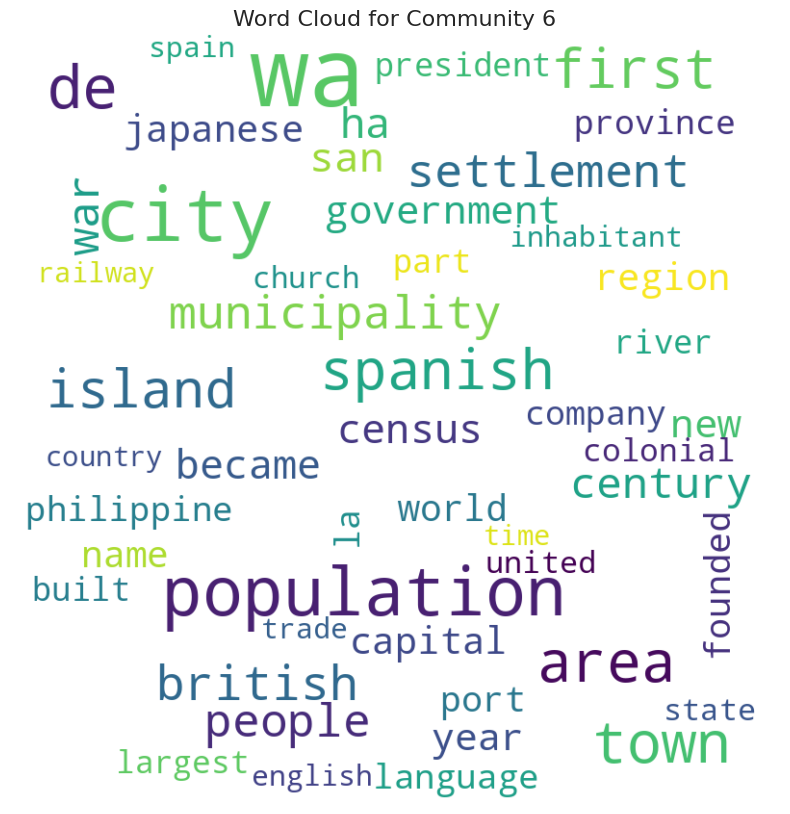

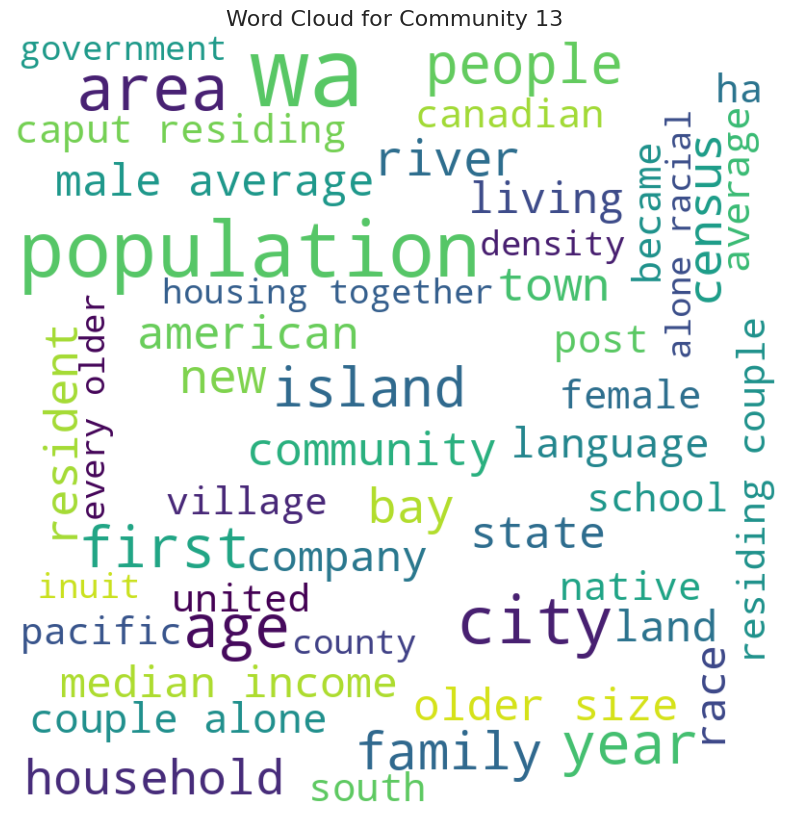

In [102]:

# Define the function to generate the word cloud
def plot_word_clouds(community_node_counts, graph):
    for i, (community_id, nodes) in enumerate(community_node_counts.items(), 1):
        top_words = []
        for node in nodes:
            top_words.extend(graph.nodes[node]['top_words'])
        top_words = ' '.join(top_words)

        # Create word cloud using the custom airplane mask
        wordcloud = WordCloud(
            width=800,
            height=800,  
            background_color='white',
            contour_width=2,
            max_words=50,
            max_font_size=100,
            min_font_size=10,
            random_state=42
        ).generate(top_words)

        # Display the word cloud with the airplane shape
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Community {community_id}", fontsize=16)
        plt.show()

similarity_top_2_communities = {community_id: nodes for community_id, nodes in community_node_counts_similarity.items() if community_id in [top[0] for top in top_communities_similarity[:2]]}
plot_word_clouds(similarity_top_2_communities, G_hist)

The first community clearly displays the correlation to colonization period.

### *Calculate cut distance for Similarity graph with the same edges per node (Ines, Ana Marija)*
We have calcualte cut distance only for Similarity graph with the same edges per node. Due to the fact that the nodes set are not the same we did not calcualte it for Similarity graph with the same number of edges.

In [106]:
# Implementing Cut Distance
distance = cut_distance(G_flights_sub, G_hist, num_samples=1000)
# distance_ana = cut_distance(G_flights_sub_isloated, G_lda_ana, num_samples=1000)

print(f"Approximate Cut Distance: {distance}")
# print(f"Approximate Cut Distance: {distance_ana}")

Approximate Cut Distance: 8.020348417443119


### *Calcualte weighted Jaccard Similarity between Flight connections subgraph and Similarity graph with the same edges per node and Similarity graph with the same number of edges without isolated nodes (Ana Marija, Ines)*

In [ ]:
# Initialize dictionary to store similarities
similarity = {}

# Calculate similarity for all nodes in G1
for node in G_flights_sub.nodes():
    similarity[node] = weighted_jaccard(G_flights_sub, G_hist)

# Get average similarity
print("Mean :", np.mean(list(similarity.values())))

Mean : 0.01551536752284009


In [109]:
# Initialize dictionary to store similarities
similarity = {}

# Calculate similarity for all nodes in G1
for node in G_lda_ana.nodes():
    similarity[node] = weighted_jaccard(G_flights_sub, G_lda_ana)

# Get average similarity
print("Mean :", np.mean(list(similarity.values())))

Mean : 0.0015794574612604903


### *Compare Similarity graph with the same edges per node and Flight connections subgraph (Ines, Ana Marija)*

In [115]:
common_nodes = compare_nodes(G_flights_sub, G_hist)

centrality_airlines = compute_node_centrality(G_flights_sub)
centrality_similarity = compute_node_centrality(G_hist)
airlines_values = []
similarity_values = []
for city in centrality_airlines.keys():
    if city in centrality_similarity.keys():
        airlines_values.append(centrality_airlines[city])
        similarity_values.append(centrality_similarity[city])
# Compare centralities (example: Pearson correlation)
airlines_values = np.array(airlines_values)
similarity_values = np.array(similarity_values)
correlation = pearsonr(airlines_values, similarity_values)
print(f"Centrality Correlation (Pearson): {correlation[0]:.3f}")

compare_edge_weights(G_flights_sub, G_hist)

print("Metrics for Airline Graph:")
compute_graph_metrics(G_flights_sub)

print("Metrics for Similarity Graph:")
compute_graph_metrics(G_hist)

jaccard_similarity_edges(G_flights_sub, G_hist)

compare_weighted_graphs(G_flights_sub, G_hist)

Nodes in both graphs: 2062
Nodes only in Graph 1: 0
Nodes only in Graph 2: 0
Centrality Correlation (Pearson): 0.960
Edge Weight Correlation (Pearson): 0.013
Edge Weight Correlation (Spearman): -0.053
Metrics for Airline Graph:
Average Path Length: None
Clustering Coefficient: 0.4872395608514852
Graph Diameter: None
Metrics for Similarity Graph:
Average Path Length: None
Clustering Coefficient: 0.6438020191104113
Graph Diameter: None
Number of edges in Graph 1: 12841
Number of edges in Graph 2: 21232
Number of common edges: 1973
Number of total unique edges: 32100
Jaccard Similarity: 0.061
Euclidean Distance (EUC): 136.0099
Manhattan Distance (MAN): 20500.4221
Canberra Distance (CAN): 31719.1872
Jaccard Distance (JAC): 0.9385


### *Compare Flight connections subgraph without isolated nodes and Similarity graph with the same number of edges without isolated nodes (Ana Marija, Ines)*

In [110]:
node_sim = {}

for flight_node in G_flights_sub_isloated.nodes():
   if flight_node in G_lda_ana_isolated.nodes():
      # calcualte similarty
      sim = jaccard_similarity_across_graphs(G_flights_sub_isloated, G_lda_ana_isolated, flight_node)
      if sim == 1:
         print("node", flight_node)
         print("flight neighbours",list(G_flights_sub_isloated.neighbors(flight_node)))
         print("similarty neighbours",list(G_lda_ana_isolated.neighbors(flight_node)))
      # save the similarty
      node_sim[flight_node] = sim

similarites = list(node_sim.values())

# Calculating various statistics
mean = statistics.mean(similarites)
median = statistics.median(similarites)
stdev = statistics.stdev(similarites)
variance = statistics.variance(similarites)
minimum = min(similarites)
maximum = max(similarites)
range_value = maximum - minimum

# Printing the results
print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {stdev}")
print(f"Variance: {variance}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Range: {range_value}")

Mean: 0.010724419456770917
Median: 0.0
Standard Deviation: 0.027360225383639792
Variance: 0.0007485819330435671
Minimum: 0.0
Maximum: 0.25
Range: 0.25


In [114]:
common_nodes = compare_nodes(G_flights_sub_isloated, G_lda_ana_isolated)

centrality_airlines = compute_node_centrality(G_flights_sub_isloated)
centrality_similarity = compute_node_centrality(G_lda_ana_isolated)
airlines_values = []
similarity_values = []
for city in centrality_airlines.keys():
    if city in centrality_similarity.keys():
        airlines_values.append(centrality_airlines[city])
        similarity_values.append(centrality_similarity[city])
# Compare centralities (example: Pearson correlation)
airlines_values = np.array(airlines_values)
similarity_values = np.array(similarity_values)
correlation = pearsonr(airlines_values, similarity_values)
print(f"Centrality Correlation (Pearson): {correlation[0]:.3f}")

compare_edge_weights(G_flights_sub_isloated, G_lda_ana_isolated)

print("Metrics for Airline Graph:")
compute_graph_metrics(G_flights_sub_isloated)

print("Metrics for Similarity Graph:")
compute_graph_metrics(G_lda_ana_isolated)

jaccard_similarity_edges(G_flights_sub_isloated, G_lda_ana_isolated)

compare_weighted_graphs(G_flights_sub_isloated, G_lda_ana_isolated)

Nodes in both graphs: 463
Nodes only in Graph 1: 1540
Nodes only in Graph 2: 15
Centrality Correlation (Pearson): -0.124
Edge Weight Correlation (Pearson): 0.132
Edge Weight Correlation (Spearman): 0.198
Metrics for Airline Graph:
Average Path Length: None
Clustering Coefficient: 0.5015915998381241
Graph Diameter: None
Metrics for Similarity Graph:
Average Path Length: None
Clustering Coefficient: 0.787869823320818
Graph Diameter: None
Number of edges in Graph 1: 12841
Number of edges in Graph 2: 12841
Number of common edges: 148
Number of total unique edges: 25534
Jaccard Similarity: 0.006
Euclidean Distance (EUC): 113.8491
Manhattan Distance (MAN): 13869.4046
Canberra Distance (CAN): 25515.3784
Jaccard Distance (JAC): 0.9942
